In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

SEED = 515
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Load Data

In [2]:
import unicodedata
import string
import os
import glob

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicode2ascii(s):
    """
    Mapping unicode characters to ascii characters. 
    """
    return ''.join([c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn' and c in all_letters])

unicode2ascii('Ślusàrski')

'Slusarski'

In [3]:
category_lines = {}
all_categories = []
for fn in glob.iglob("../assets/data/names/*.txt"):
    category = os.path.basename(fn).replace('.txt', '')
    all_categories.append(category)    
    with open(fn, encoding='utf-8') as f:
        category_lines[category] = [unicode2ascii(line) for line in f]
    
n_categories = len(all_categories)

category_lines['Italian'][:5]

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']

In [4]:
def line2tensor(line):
    """
    Transforming a sentence to a <line length x 1 x n_letters> tensor of one-hot embeddings. 
    """
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i, 0, all_letters.index(letter)] = 1
    return tensor

line2tensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

# Define Model

In [5]:
class RNN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        """
        An RNN which keeps a hidden state, and produces an output for each step. 
        """
        super(RNN, self).__init__()
        self.i2h = nn.Linear(in_size+hidden_size, hidden_size)
        self.i2o = nn.Linear(in_size+hidden_size, out_size)
        self.hidden_size = hidden_size
        
    def forward(self, ins, hidden):
        """
        Forward one step for a single sample. 
        Implement multiple samples and steps OUTSIDE. 
        """
        combined = torch.cat([ins, hidden], dim=1)
        hidden = self.i2h(combined)
        outs = self.i2o(combined)
        outs = F.log_softmax(outs, dim=-1)
        return outs, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [6]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
ins = line2tensor('Albert')
hidden = rnn.init_hidden()
outs, next_hidden = rnn(ins[0].view(1, -1), hidden)
outs

tensor([[-2.9172, -2.9937, -2.9209, -2.9403, -2.8247, -2.9239, -2.8504, -2.7566,
         -2.9661, -2.9191, -2.8964, -2.9435, -2.8962, -2.9012, -2.8137, -2.8280,
         -2.9047, -2.8606]], grad_fn=<LogSoftmaxBackward>)

In [7]:
def category_from_outs(outs):
    category_idx = outs.argmax(dim=1).item()
    return all_categories[category_idx], category_idx

print(category_from_outs(outs))

('Czech', 7)


In [8]:
data = {}
for category, lines in category_lines.items():
    data[category] = []
    category_var = torch.tensor([all_categories.index(category)], dtype=torch.long)
    for line in lines:
        line_var = line2tensor(line)
        data[category].append([line_var, category_var])

data['English'][0]

[tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0.,

# Train Model

In [9]:
loss_func = nn.NLLLoss()
learning_rate = 0.005

def train(category_var, line_var):
    hidden = rnn.init_hidden()
    
    # Forward pass
    for i in range(line_var.size(0)):
        outs, hidden = rnn(line_var[i], hidden)
    
    # Calculate loss
    loss = loss_func(outs, category_var)

    # Backward propagation
    rnn.zero_grad()
    loss.backward()
    
    # Update weights
    with torch.no_grad():
        for p in rnn.parameters():
            p.add_(-learning_rate, p.grad)
    
    return outs, loss.item()

In [10]:
import time
import random

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = np.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start_time = time.time()
for iter_i in range(n_iters):
    category = random.choice(all_categories)
    line_var, category_var = random.choice(data[category])
    outs, loss = train(category_var, line_var)
    current_loss += loss
    
    # Print iter number, loss, name and guess
    if (iter_i+1) % print_every == 0:
        guess, guess_i = category_from_outs(outs)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s %s' % ((iter_i+1), (iter_i+1) / n_iters * 100, time_since(start_time), loss, guess, correct))

    # Add current loss avg to list of losses
    if (iter_i+1) % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.5124 Italian ✗ (Spanish)
10000 10% (0m 14s) 1.6369 Chinese ✗ (Korean)
15000 15% (0m 21s) 3.1857 Portuguese ✗ (Greek)
20000 20% (0m 28s) 0.8522 Chinese ✓
25000 25% (0m 35s) 2.4749 Irish ✗ (Arabic)
30000 30% (0m 42s) 2.4158 Czech ✗ (Polish)
35000 35% (0m 49s) 2.4356 German ✗ (English)
40000 40% (0m 57s) 1.8811 Spanish ✗ (Portuguese)
45000 45% (1m 4s) 1.4652 Scottish ✓
50000 50% (1m 11s) 1.0936 Spanish ✓
55000 55% (1m 18s) 0.6437 Chinese ✓
60000 60% (1m 25s) 1.9464 Chinese ✗ (Scottish)
65000 65% (1m 32s) 0.6679 Chinese ✓
70000 70% (1m 39s) 1.1052 Korean ✓
75000 75% (1m 46s) 0.1523 Polish ✓
80000 80% (1m 53s) 1.6289 Portuguese ✗ (Spanish)
85000 85% (2m 0s) 0.7907 Korean ✓
90000 90% (2m 9s) 0.4876 Scottish ✓
95000 95% (2m 16s) 1.3603 English ✓
100000 100% (2m 23s) 0.0359 Greek ✓


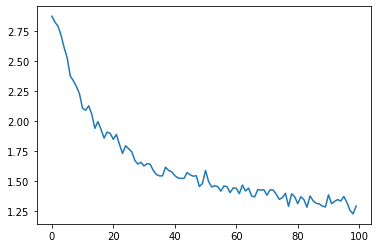

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(all_losses)

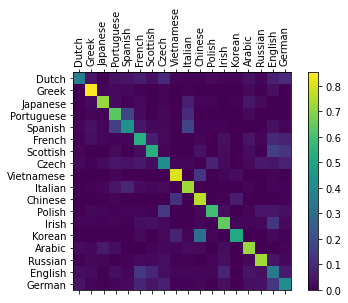

In [12]:
import matplotlib.ticker as ticker
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category = random.choice(all_categories)
    line_var, category_var = random.choice(data[category])
    output = evaluate(line_var)
    guess, guess_i = category_from_outs(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()